# Analysis: Why are some European cities more expensive on Airbnb?

**Objective:** 
The goal of this analysis is to go beyond simple descriptive statistics and identify the drivers behind price disparities across different European cities. We aim to answer: *"Why is Amsterdam so much more expensive than Athens?"* by looking at factors like location, safety, and attraction density.

**Key Steps:**
1.  **Data Loading & Cleaning:** Prepare the dataset and handle outliers.
2.  **The "What":** Establish the price hierarchy of cities.
3.  **The "Why":** correlate prices with city characteristics (Crime, Distance to Center, Attractions).
4.  **Conclusion:** Summary of drivers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest

# Set visual style
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

## 1. Data Loading & Overview

In [2]:

df = pd.read_csv("transformed_data/merged_data_1.csv", index_col="id")

# Create Log Price immediately for analysis
df['log_price'] = np.log1p(df['price_total'])

df.head()

,price_total,room_type,is_shared_room,is_private_room,max_guests,is_superhost,is_multi_listing,is_business_listing,cleanliness_score,guest_satisfaction_score,...,latitude,city,day_type,district,state,country_code,country_name,Crime_Index,Safety_Index,log_price
id,,,,,,,,,,,,,,,,,,,,,
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,52.41772,Amsterdam,weekday,Gemeente Landsmeer,North Holland,NL,Netherlands,25.7,74.3,5.273172
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,52.37432,Amsterdam,weekday,Gemeente Amsterdam,North Holland,NL,Netherlands,25.7,74.3,5.844257
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,52.36103,Amsterdam,weekday,Gemeente Diemen,North Holland,NL,Netherlands,25.7,74.3,5.580112
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,52.37663,Amsterdam,weekday,Gemeente Amsterdam,North Holland,NL,Netherlands,25.7,74.3,6.074264
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,52.37508,Amsterdam,weekday,Gemeente Amsterdam,North Holland,NL,Netherlands,25.7,74.3,6.187346


In [3]:
print(f"Dataset Shape: {df.shape}")
print("Missing Values:\n", df.isna().sum().sort_values(ascending=False).head(5))

Dataset Shape: (51707, 28)
Missing Values:
 district       11092
state           4586
price_total        0
room_type          0
max_guests         0
dtype: int64


## 2. Price Distribution Analysis
Before comparing cities, we must understand the target variable `price_total`. Real estate data is typically right-skewed.

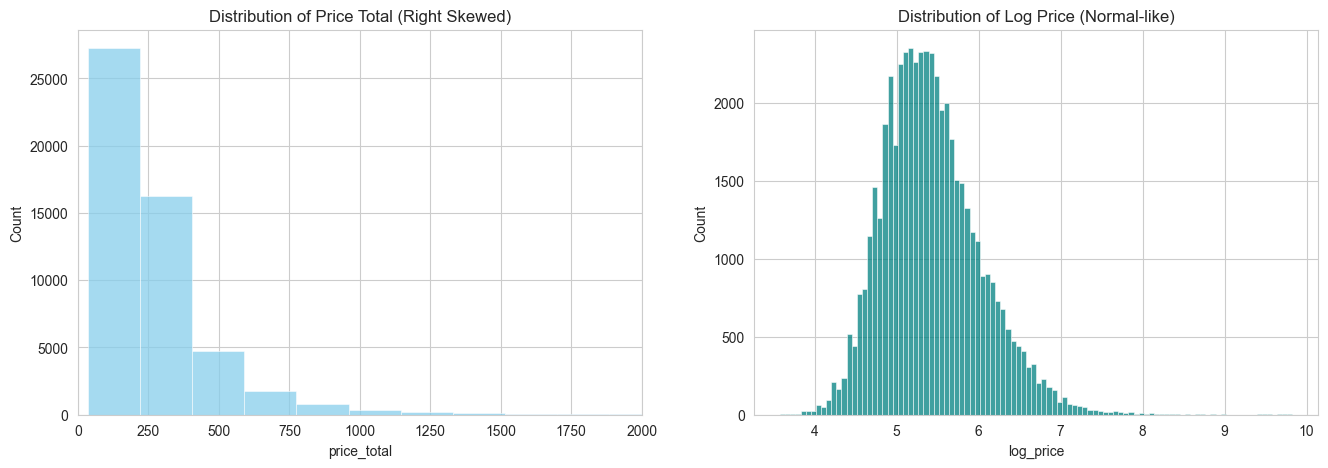

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Raw Price
sns.histplot(df['price_total'], bins=100, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Price Total (Right Skewed)')
ax[0].set_xlim(0, 2000) # Limiting x-axis to see the bulk of data

# Log Price
sns.histplot(df['log_price'], bins=100, ax=ax[1], color='teal')
ax[1].set_title('Distribution of Log Price (Normal-like)')

plt.show()

### Handling Extremes
We flag outliers using the IQR method but **retain them** for the analysis, as high prices in cities like Paris or Amsterdam are often legitimate luxury listings rather than data errors. We will primarily use `median` and `log_price` for robust comparisons.

In [5]:
Q1 = df['price_total'].quantile(0.25)
Q3 = df['price_total'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

df['is_outlier'] = (df['price_total'] > upper_bound) | (df['price_total'] < lower_bound)
print(f"Identified {df['is_outlier'].sum()} IQR outliers ({df['is_outlier'].mean():.1%})")

Identified 3662 IQR outliers (7.1%)


## 3. The "What": Comparing Price Levels by City
Let's establish the ranking. Which cities are the most expensive?

C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_21656\3261151480.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='city', y='log_price', data=df, order=city_order, palette='viridis')


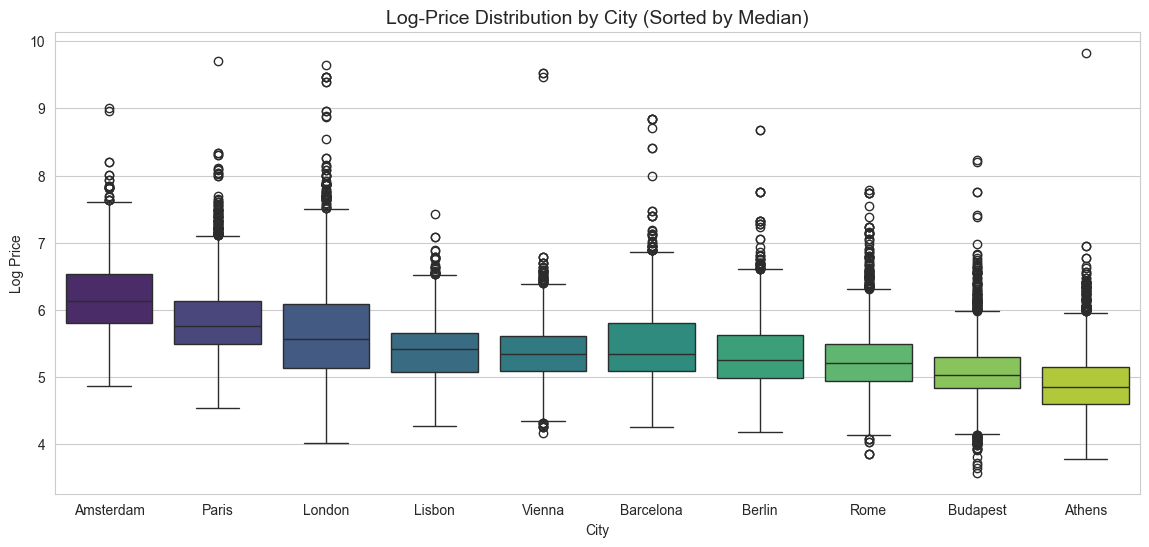

In [6]:
# Order cities by median price
city_order = df.groupby('city')['price_total'].median().sort_values(ascending=False).index

plt.figure(figsize=(14, 6))
sns.boxplot(x='city', y='log_price', data=df, order=city_order, palette='viridis')
plt.title('Log-Price Distribution by City (Sorted by Median)', fontsize=14)
plt.ylabel('Log Price')
plt.xlabel('City')
plt.show()

C:\Users\Seif Khaled\AppData\Local\Temp\ipykernel_21656\4035122594.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=median_prices.index, y=median_prices.values, palette='viridis')


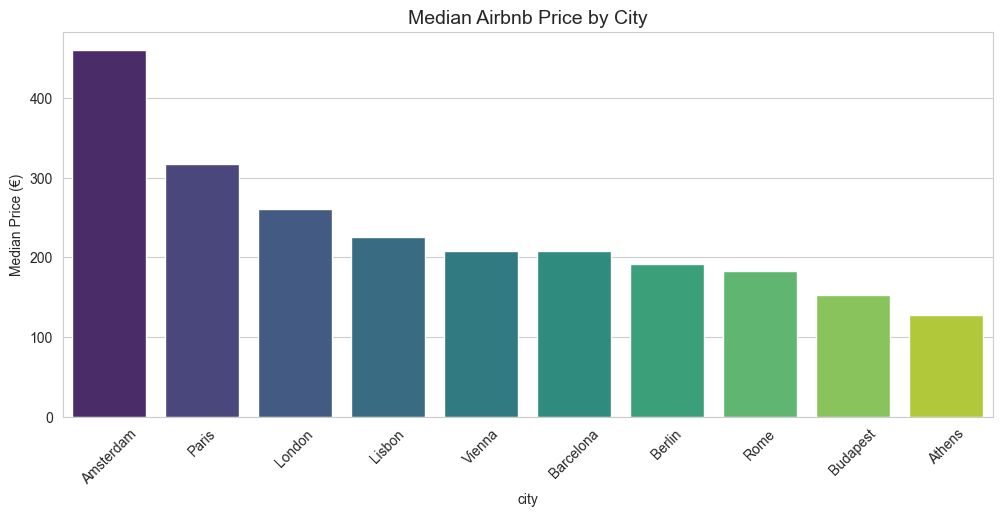

In [7]:
# Bar chart for clearer ranking of actual prices
median_prices = df.groupby('city')['price_total'].median().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=median_prices.index, y=median_prices.values, palette='viridis')
plt.title('Median Airbnb Price by City', fontsize=14)
plt.ylabel('Median Price (€)')
plt.xticks(rotation=45)
plt.show()

## 4. The "Why": Investigating Price Drivers
We have established that **Amsterdam, Paris, and London** are the most expensive, while **Athens and Budapest** are the cheapest.

Why? We will examine the relationship between Price and:
1.  **Attractions:** Do expensive cities have more/better attractions?
2.  **Safety:** Is there a correlation between low crime and high prices?
3.  **Distance:** Does the "distance penalty" (cheaper as you go further out) apply equally?

In [12]:
# Aggregate key metrics by city to find patterns
city_profile = df.groupby('city').agg(
    Median_Price=('price_total', 'median'),
    Attraction_Index_norm=('attraction_index_norm', 'mean'),
    Restaurant_Index_norm=('restaurant_index_norm', 'mean'),
    Safety_Index=('Safety_Index', 'mean'),
    Dist_to_Center=('distance_city_center', 'mean'),
    Guest_Satisfaction=('guest_satisfaction_score', 'mean')
).sort_values('Median_Price', ascending=False)

# Normalize for easier comparison (Min-Max scaling for display)
city_profile_norm = (city_profile - city_profile.min()) / (city_profile.max() - city_profile.min())

display(city_profile)

,Median_Price,Attraction_Index_norm,Restaurant_Index_norm,Safety_Index,Dist_to_Center,Guest_Satisfaction
city,,,,,,
Amsterdam,460.244183,14.246499,26.097566,74.3,2.825052,94.514423
Paris,317.597167,18.204358,42.589111,42.0,2.995823,92.037530
London,261.294950,20.537398,11.234105,44.4,5.326421,90.645652
Lisbon,225.375235,7.324730,28.274084,67.4,1.966893,91.093875
Vienna,208.494028,8.762474,4.239580,71.6,3.139488,93.731128
Barcelona,208.299393,16.636220,19.376528,48.1,2.116982,91.109072
Berlin,191.175096,16.803111,30.666967,55.5,5.257093,94.323671
Rome,182.591822,10.426968,25.078056,52.7,3.026982,93.122300
Budapest,152.982093,12.675248,34.529089,66.1,1.872763,94.585281


### Insights from City Profiles:
* **Amsterdam (Most Expensive):** Scores very high on Safety (74.3) and maintains high satisfaction, despite not having the highest raw attraction index.
* **Paris & London:** Have huge Attraction and Restaurant indices (high demand drivers), justifying higher prices.
* **Athens (Cheapest):** Has a significantly lower Safety Index (55.2) compared to Amsterdam, despite having decent guest satisfaction.

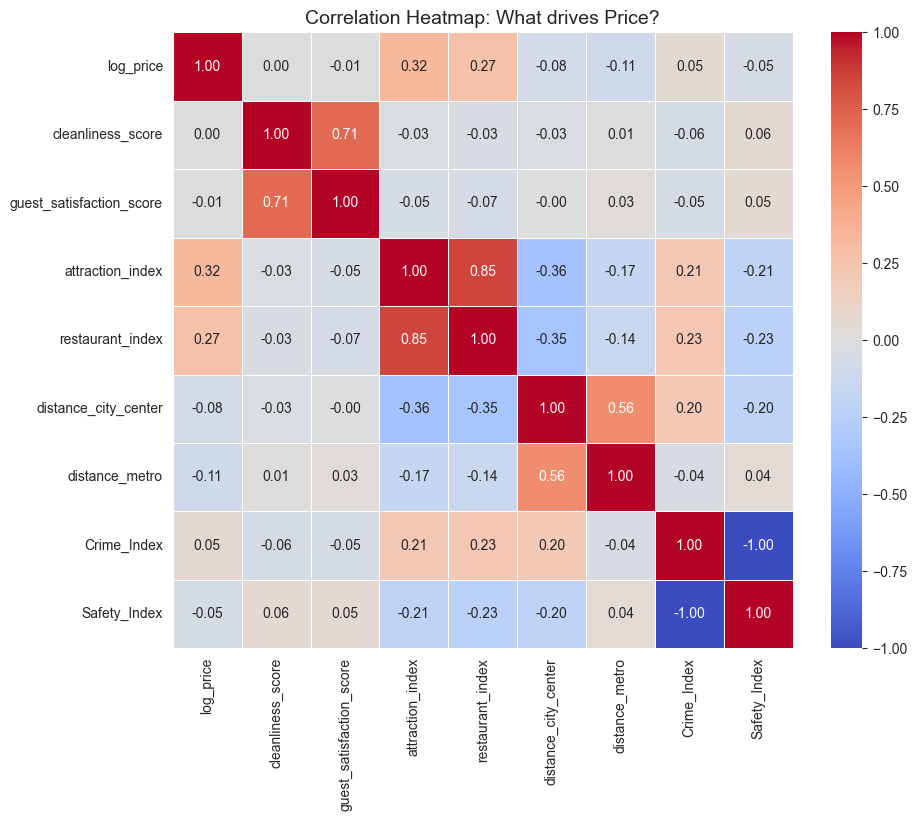

In [9]:
# Correlation Matrix
# Which features correlate most strongly with Log Price across the whole dataset?
cols_to_corr = [
    'log_price', 'cleanliness_score', 'guest_satisfaction_score', 
    'attraction_index', 'restaurant_index', 
    'distance_city_center', 'distance_metro', 
    'Crime_Index', 'Safety_Index'
]

plt.figure(figsize=(10, 8))
sns.heatmap(df[cols_to_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: What drives Price?', fontsize=14)
plt.show()

### Structural Differences: Distance & Safety
Let's visualize the two strongest structural drivers: **Distance to Center** and **Safety/Crime**.

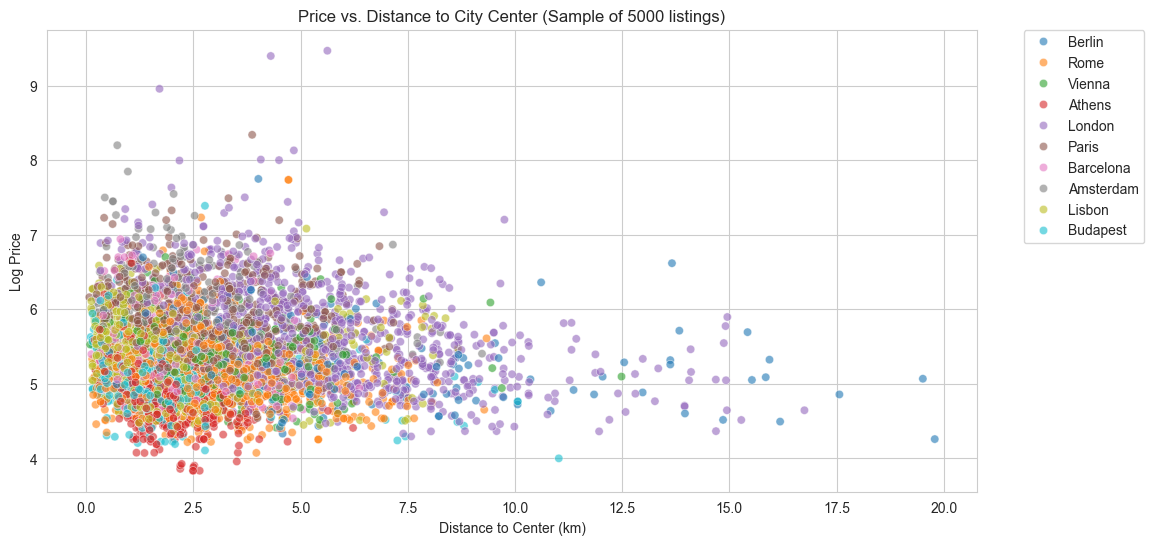

In [10]:
# Scatter: Price vs Distance (Are people paying for central locations?)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df.sample(5000, random_state=42), 
                x='distance_city_center', 
                y='log_price', 
                hue='city', 
                alpha=0.6)
plt.title('Price vs. Distance to City Center (Sample of 5000 listings)')
plt.xlabel('Distance to Center (km)')
plt.ylabel('Log Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

**Observation:** There is a clear negative correlation (price drops as distance increases). However, notice that **Amsterdam (dark blue dots)** remains expensive even at 4-6km from the center, whereas **Athens** drops off in price very quickly.

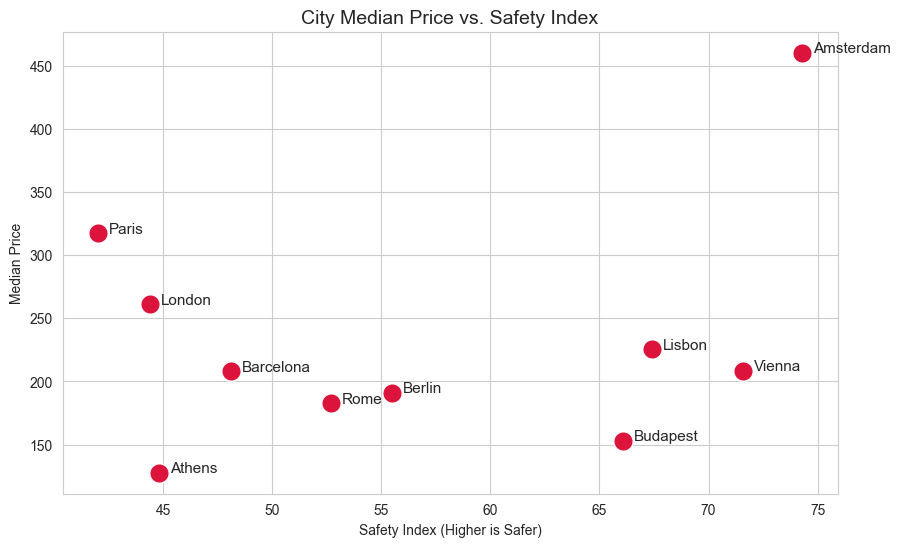

In [11]:
# Price vs Crime Index (City Level)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=city_profile, x='Safety_Index', y='Median_Price', s=200, color='crimson')

for city in city_profile.index:
    plt.text(city_profile.loc[city, 'Safety_Index']+0.5, 
             city_profile.loc[city, 'Median_Price'], 
             city, fontsize=11)

plt.title('City Median Price vs. Safety Index', fontsize=14)
plt.xlabel('Safety Index (Higher is Safer)')
plt.ylabel('Median Price')
plt.grid(True)
plt.show()

## 5. Conclusion: Why are some cities more expensive?

Based on the analysis, the price disparity in European Airbnb markets is driven by three main factors:

1.  **The Safety Premium:** There is a strong positive relationship between Safety and Price. Amsterdam, the most expensive city, has one of the highest Safety Indices (74.3). Conversely, Rome and Athens have lower safety scores and lower median prices.
2.  **Attraction Density (Demand):** Cities like Paris and London have massive Attraction and Restaurant Indices. This density creates high demand, sustaining higher prices despite having higher crime rates than Amsterdam.
3.  **Location Elasticity:** In expensive cities (Amsterdam, Paris), prices remain relatively high even further from the center. In cheaper cities (Athens, Budapest), moving slightly away from the center results in a sharp price drop.

**Summary:** 
* **Amsterdam** commands the highest prices due to a combination of high safety, high guest satisfaction, and likely supply constraints (smaller city vs London/Paris).
* **Athens/Budapest** offer high value (good satisfaction scores) but command lower prices due to lower economic baselines and safety perceptions.